In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats

In [2]:
sys.path.append("../")

In [3]:
from lib import lightcurve as lc

In [4]:
def simulate_outcome(n=5, fp=0.3):
    n_s = n_events = n
    flare_prob = fp
    
    bins = np.linspace(0.,100,101)
    state = np.random.choice([1, 0], size=(n_s,len(bins)-1), p=[flare_prob, 1-flare_prob])
    
    lcs = np.array([lc.LightCurve(bins,state[i]) for i in range(len(state))])
    
    events = np.round(np.random.uniform(low=0., high=100., size=(n_events,1)))
    
    ev_states = np.array([lcs[i](events[i])[0] for i in range(len(events))], dtype=np.bool)
    
    coinc = np.sum(ev_states)
    expected_coinc = np.sum([l.flare_probability for l in lcs])
    
    p_coinc = np.array([l.flare_probability for l in lcs[ev_states]])  
    p_noncoinc = np.array([1 - l.flare_probability for l in lcs[~ev_states]])
    
    l = -np.log10(np.product(p_coinc) * np.product(p_noncoinc))
    
    return coinc, l

In [5]:
def simulate_outcome_signal(n=5, n_signal=1, fp=0.3):
    n_inj = n_signal
    n_s = n
    n_events = n - n_inj
    flare_prob = fp
    
    bins = np.linspace(0.,100,101)
    state = np.random.choice([1, 0], size=(n_s,len(bins)-1), p=[flare_prob, 1-flare_prob])
    
    lcs = np.array([lc.LightCurve(bins,state[i]) for i in range(len(state))])
    
    events = np.round(np.random.uniform(low=0., high=100., size=(n_events,1)))
    
    ev_states = np.array([lcs[i](events[i])[0] for i in range(len(events))], dtype=np.bool)
    ev_coinc = np.ones(n_inj, dtype=np.bool)
    ev_states = np.append(ev_states, ev_coinc)
    
    coinc = np.sum(ev_states)
    expected_coinc = np.sum([l.flare_probability for l in lcs])
    
    p_coinc = np.array([l.flare_probability for l in lcs[ev_states]])  
    p_noncoinc = np.array([1 - l.flare_probability for l in lcs[~ev_states]])
    
    l = -np.log10(np.product(p_coinc) * np.product(p_noncoinc))
    
    return coinc, l

In [6]:
sim = dict()
for i in range(10):
    sim[i] = list()
    for j in range(10000):
        out_inj = simulate_outcome_signal(10, i, 0.4)
        sim[i].append(out_inj[0])

In [7]:
sim = pd.DataFrame(sim)

In [8]:
sim.describe()

,0,1,2,3,4,5,6,7,8,9
count,10000.0000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,3.9692,4.592900,5.202800,5.790100,6.407900,6.985100,7.602100,8.188000,8.803800,9.401300
std,1.5547,1.471729,1.380747,1.272951,1.192418,1.094257,0.984415,0.857747,0.693652,0.490186
min,0.0000,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000
25%,3.0000,4.000000,4.000000,5.000000,6.000000,6.000000,7.000000,8.000000,8.000000,9.000000
50%,4.0000,5.000000,5.000000,6.000000,6.000000,7.000000,8.000000,8.000000,9.000000,9.000000
75%,5.0000,6.000000,6.000000,7.000000,7.000000,8.000000,8.000000,9.000000,9.000000,10.000000
max,9.0000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


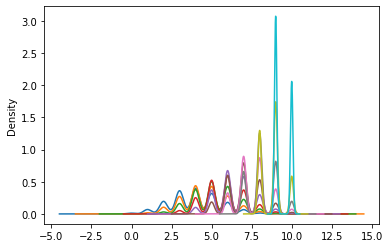

In [10]:
for i in sim.columns:
    sim[i].plot.kde()

In [41]:
kernel_bkg = stats.gaussian_kde(sim[0])

In [42]:
kernel_sig = []
for col in sim.drop([0]).columns:
    kernel_sig.append(stats.gaussian_kde(sim[col]))

In [43]:
def likelihood_ratio(x):
    bkg = kernel_bkg(x)
    
    sig = []
    for k in kernel_sig:
        sig.append(k(x))
    sig = np.array(sig)
    
    ts = -2*np.log(bkg/sig)
    
    return ts

In [50]:
ts = likelihood_ratio(6)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


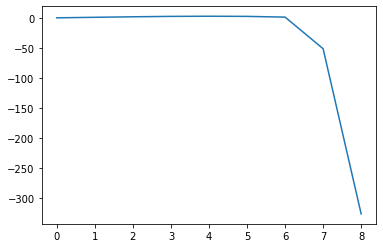

In [51]:
fig, ax = plt.subplots()
ax.plot(ts)

In [ ]:
fig, ax = plt.subplots()
x = np.linspace(0,5,1000)
ax.plot(x, kernel(x))

In [ ]:
for i, col in enumerate(sim.columns):
    sim[f"cum_{col}"] = sim[col].cumsum() / sim[col].sum()

In [ ]:
sim